<a href="https://colab.research.google.com/github/phoebezhouhuixin/NLPwithTF/blob/master/sequencemodels_GloVe_asmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd

# tokenize, vectorize and pad before feeding to the pretrained embedding layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [ ]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-07-19 16:30:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  32.9MB/s    in 6.9s    

2020-07-19 16:30:50 (32.9 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



# Load data

In [ ]:
pd.read_csv("/tmp/training_cleaned.csv").head()
# target 0 is negative, 4 is positive

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
num_sentences = 0
corpus = []

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        # Create list items where the first item is the text, found in row[5], and the second is the label.
        # For the labels, change from 0 and 4, to 0 and 1 instead. 
        list_item=[]
        list_item.append(row[5]) # text
        if row[0] == "0":
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [ ]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [ ]:
training_size = 160000 # we will just use 160 000 texts for training
test_portion=.1 # i.e. 16000 other texts
sentences=[] # for tokenization fitting
sentences_test=[]
labels = []
labels_test=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])
for x in range(int(training_size*test_portion)):
    sentences_test.append(corpus[training_size+x][0])
    labels_test.append(corpus[training_size+x][1])

In [ ]:
sentences[0], len(sentences_test)

('@emilybelgard: Oh you HAVE arrived! Genius. ', 16000)

# Cleaning

In [ ]:
# remove urls and @mentions
import re
import string
print(re.sub(r"\S*@\S*", "", "@mention hi"))
print(re.sub(r"\S*@\S*", "", "hi1 hi@gmail.com"))
print(re.sub(r"@\S+", "", "hi1 hi2@gmail.com hi3"))
re.sub(r"http\S+", "", "hello? 1 2 4.   www.google.com https://colab.research.google.com/drive/1kDnJD0twReX_EeRTTxAGzzRG-6Qw_9XH#scrollTo=sYiuevLvayJp")

 hi
hi1 
hi1 hi2 hi3


'hello? 1 2 4.   www.google.com '

In [ ]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_list = stopwords.words("english")
stopword_list.remove("not")
# stopword_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# remove numerics
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

In [ ]:
tokenizer.tokenize("hello? 1 2 4.   www.google.com https://colab.research.google.com/drive/1kDnJD0twReX_EeRTTxAGzzRG-6Qw_9XH#scrollTo=sYiuevLvayJp")

['hello',
 'www',
 'google',
 'com',
 'https',
 'colab',
 'research',
 'google',
 'com',
 'drive',
 'kDnJD',
 'twReX',
 'EeRTTxAGzzRG',
 'Qw',
 'XH',
 'scrollTo',
 'sYiuevLvayJp']

In [ ]:
# hence, the overall cleaning function is:

def clean_text(rowtext): # rowtext is a string
    rowtext = re.sub(r"\S*@\S*", "", rowtext)
    rowtext = re.sub(r"http\S+", "",rowtext)
    rowtext = re.sub(r"@\S+", "",rowtext)
    clean_word_list = tokenizer.tokenize(rowtext)
    rowtext = " ".join([word for word in clean_word_list if word not in stopword_list])
    return rowtext

In [ ]:
for i,rowtext in enumerate(sentences):
    sentences[i] = rowtext.replace(rowtext, clean_text(rowtext))
for i,rowtext in enumerate(sentences_test):
    sentences_test[i] = rowtext.replace(rowtext, clean_text(rowtext))
sentences[:10]

['Oh HAVE arrived Genius',
 'Take Goodnight',
 'GOOD MORNING There shortcuts place worth going',
 'watching Hannah Montana season wahee episode',
 'yes still good people aheim',
 'Thanks idea chicken quesadillas',
 'playing call duty bro',
 'I know',
 'I say dooooooode',
 'I Chips Ahoy well']

# Tokenization and vectorization

In [ ]:
oov_tok = "UNK"
max_length = 16
trunc_type='post'
padding_type='post'

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
sequences_test = tokenizer.texts_to_sequences(sentences_test)
padded = pad_sequences(sequences, padding = padding_type, truncating = trunc_type, maxlen = max_length)
padded_test = pad_sequences(sequences_test, padding = padding_type, truncating = trunc_type, maxlen = max_length)

In [ ]:
print(sequences[0], vocab_size)
list(word_index.keys())[list(word_index.values()).index(90)] 

[33, 161, 1271, 2319] 67669


'never'

# Import embedding weights

In [ ]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-07-19 16:31:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 66.102.1.128, 74.125.71.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   161MB/s    in 2.1s    

2020-07-19 16:31:17 (161 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [ ]:
embedding_dim = 100
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim)); 
# embeddings_matrix.shape --> (67670, 100)
# need to +1 because of reasons idgi


for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word); # dict.get(key)
    if embedding_vector is not None: 
        embeddings_matrix[i] = embedding_vector;
    # all our UNKs will still be encoded as np.zeros of length `embedding_dim`

In [ ]:
embeddings_index["thank"].all() == embeddings_matrix[90].all()

True

In [ ]:
embeddings_matrix.shape

(67670, 100)

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
corpus = 'I like turtles'
num_words = len(corpus.split()) # 3

oov = 'OOV'
tokenizer = Tokenizer(num_words=num_words + 2, oov_token=oov) # NOTE the +2
tokenizer.fit_on_texts(corpus.split())
print(f'word_index: {tokenizer.word_index}')

text = 'I like turtles'.split()
print(f'{text}: {tokenizer.texts_to_sequences(text)}')

text = 'I like marshmallows'.split() 
print(f'{text}: {tokenizer.texts_to_sequences(text)}')
######################
tokenizer = Tokenizer(num_words=num_words + 1, oov_token=oov) # NOTE the +1
tokenizer.fit_on_texts(corpus.split())
print(f'\n\nword_index: {tokenizer.word_index}')

text = 'I like turtles'.split()
print(f'{text}: {tokenizer.texts_to_sequences(text)}')

text = 'I like marshmallows'.split() 
print(f'{text}: {tokenizer.texts_to_sequences(text)}')
# WEIRD. WHAT

word_index: {'OOV': 1, 'i': 2, 'like': 3, 'turtles': 4}
['I', 'like', 'turtles']: [[2], [3], [4]]
['I', 'like', 'marshmallows']: [[2], [3], [1]]


word_index: {'OOV': 1, 'i': 2, 'like': 3, 'turtles': 4}
['I', 'like', 'turtles']: [[2], [3], [1]]
['I', 'like', 'marshmallows']: [[2], [3], [1]]


# Model

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, 
                              input_length=max_length, weights=[embeddings_matrix], trainable=False),
                             # vocab_size+1 as input_dim, and embedding_dim as output_dim,
                             # because the embeddings_matrix is of that shape

    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=False)),
    tf.keras.layers.Dense(6, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=["accuracy"])
model.summary()

num_epochs = 50
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 2)
x_train, x_valid, y_train, y_valid = train_test_split(padded, labels, test_size=0.2, shuffle= True)
history = model.fit(np.array(x_train), np.array(y_train), epochs=num_epochs, callbacks = [callback], validation_data=(np.array(x_valid), np.array(y_valid)))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 100)           6767000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                25728     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 6,793,125
Trainable params: 26,125
Non-trainable params: 6,767,000
_________________________________________________________________
Epoch 1/50
4000/4000 [==============================] - 45s 11ms/step - loss: 0.5401 - accuracy: 0.7234 - val_loss: 0.5105 - val_accuracy: 0.7471
Epoch 2/50
4000/4000 [==============================] - 44s 11ms/step - loss: 0.4916 - accu

In [ ]:
model.evaluate(padded_test, np.array(labels_test))

500/500 [==============================] - 2s 5ms/step - loss: 0.5026 - accuracy: 0.7549


[0.5026487112045288, 0.7548750042915344]

<Figure size 432x288 with 0 Axes>

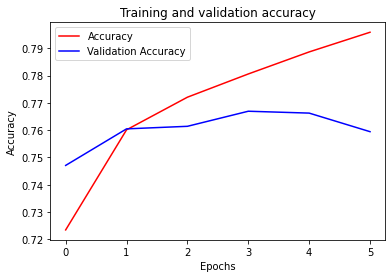

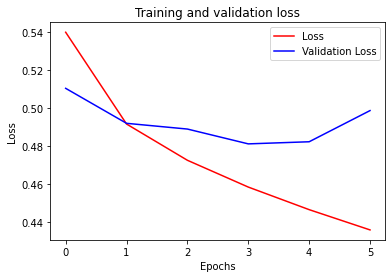

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!